In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'


2025-04-30 13:10:47.559093: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 13:10:47.583546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746040247.604802    8361 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746040247.611767    8361 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 13:10:47.637628: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### setup

In [2]:
def get_biome_param_names(b, u_params, pft_params):
    
    with open(utils_path+"/biome_configs.pkl", "rb") as f:
        biome_configs = pickle.load(f)

    param_names = list(u_params)
    for pft in biome_configs[b]['pfts']:
        pft_param_names = [f"{param}_{pft}" for param in pft_params]
        param_names.extend(pft_param_names)

    return param_names

In [3]:
#======================== set up ============================
# get parameter information
with open(utils_dir+"/param_names.pkl", "rb") as f:
    param_info = pickle.load(f)
u_params = param_info['u_params']
pft_params = param_info['pft_params']

# get biome information
with open(utils_dir+"/biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)

# get observations & set stdev so high the optimization ignores some biome/variable combinations
obs = xr.open_dataset(utils_path + 'wave2_obsStatistics_sudokuBiomes.nc')
obs_biome = obs.copy()
obs_biome['biomassC_stdev'].loc[{'biome': 12}] = 100

# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]

# Build universal_set tensor
universal_set = tf.constant(default_params[u_params].iloc[[0]].to_numpy(),dtype=tf.float64)

x_default = tf.constant(default_params.drop(columns=u_params).iloc[[0]].to_numpy(), dtype=tf.float64)


2025-04-30 13:11:02.265496: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
paths = {
    'lai': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomelai_compiled/',
    'gpp': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomegpp_compiled/',
    'biomass': '/glade/u/home/linnia/ctsm6_ppe/calibration/emulators_biomebiomass_compiled/'
}

#biomes = [1,2,3,5,6,7,8,9,10,11,12,13] # excluding biome4
biomes = [1,2,3]
param_indices = []
targets = []
stdevs = []
emulators = []  

for b in biomes:
    biome_name = biome_configs[b]['name']
    param_names = get_biome_param_names(b,u_params,pft_params)
    param_ix = [default_params.columns.get_loc(p)for p in param_names]
    
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    param_indices.append(param_ix)
    
    targets.extend([
        tf.convert_to_tensor(obs_biome.LAI_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_mean.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.biomassC_mean.isel(biome=b).values, dtype=tf.float64)
    ])
    stdevs.extend([
        tf.convert_to_tensor(obs_biome.LAI_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.GPP_stdev.isel(biome=b).values, dtype=tf.float64),
        tf.convert_to_tensor(obs_biome.biomassC_stdev.isel(biome=b).values, dtype=tf.float64)
    ])

    emulators.extend([
        tf.saved_model.load(f"{paths['lai']}{biome_name}"),
        tf.saved_model.load(f"{paths['gpp']}{biome_name}"),
        tf.saved_model.load(f"{paths['biomass']}{biome_name}")
    ])
    
targets = tf.stack(targets, axis=0)  
stdevs = tf.stack(stdevs, axis=0)   


In [5]:
# ——— for fast graph execution ———
lengths = [len(arr) for arr in param_indices]     # list of Python ints

emulator_array = []
for m,input_dim in zip(emulators, lengths):
    sig = tf.TensorSpec([None, input_dim], tf.float64)
    f = tf.function(lambda X, _m=m: _m.compiled_predict_f(X)[0], input_signature=[sig])
    emulator_array.append(f)

### Functions

In [6]:

@tf.function
def optimization_step_batch(x, universal_set, emulator_array, param_indices, optimizer, x_default, barrier_strength=1, lambda_penalty=0.01):
    with tf.GradientTape() as tape:
        batch = tf.shape(x)[0]
        u_tiled = tf.tile(universal_set, [batch, 1])   
        x_full = tf.concat([u_tiled, x], axis=1)
        per_model_losses = []
        
        # loop over metrics and biomes in stacked 1D arrays. 
        for i in range(len(emulator_array)):
            model   = emulator_array[i]

            target = tf.reshape(targets[i], (1, -1))
            stdev = tf.reshape(stdevs[i], (1, -1))
            target_tiled = tf.tile(target, [batch, 1])
            stdev_tiled = tf.tile(stdev, [batch, 1])
        
            ix  = param_indices[i]          
            x_biome = tf.gather(x_full, ix, axis=1)
            y_pred = model(x_biome)
            z = tf.abs((y_pred - target_tiled)/stdev_tiled)
            
            # size [batch]
            loss_i = tf.reduce_mean(z**2, axis=1)
            per_model_losses.append(loss_i)
            
        loss_per_sample = tf.add_n(per_model_losses)
        data_loss = tf.reduce_mean(loss_per_sample) # overall scalar loss = average over the batch
        max_z = tf.sqrt(tf.reduce_max(loss_per_sample)) # worst individual biome/init zscore

        # Penalty for moving from init
        # sum over the parameter‐axis (axis=1) → shape [batch]
        x_default_tiled = tf.tile(x_default, [batch, 1])
        sum_abs = tf.reduce_sum(tf.abs(x - x_default_tiled), axis=1)
        # average across batch 
        penalty = tf.reduce_mean(sum_abs)
        
        ratio = penalty / lambda_penalty
        factor = tf.maximum(ratio, 1.0)
        total_loss = data_loss * factor
        
        # penalty for being close to/outside of bounds
        barrier = tf.reduce_mean(1.0 / (x + 1e-6) + 1.0 / (1.0 - x + 1e-6))
        total_loss = total_loss * (1.0 + barrier_strength * barrier)
        
    grads = tape.gradient(total_loss, [x])
    optimizer.apply_gradients(zip(grads, [x]))
    x.assign(tf.clip_by_value(x, 0.0, 1.0))
    return total_loss, max_z, data_loss, penalty/lambda_penalty, barrier_strength*barrier

In [7]:

def run_optimization(x, universal_set, emulator_array, param_indices, x_default, maxiter, lr, lr_decay_steps, checkpoint_N, epsilon, barrier_strength, lambda_penalty=0.0):

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr,
        decay_steps=lr_decay_steps,
        decay_rate=0.5,
        staircase=True)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    history_total_loss = []
    history_max_z = []
    history_data_loss = []
    history_penalty = []
    history_barrier = []
    
    for step in range(maxiter):

        total_loss, max_z, data_loss, penalty, barrier_loss = optimization_step_batch(x, universal_set, emulator_array, param_indices, optimizer, x_default, barrier_strength, lambda_penalty)

        # log
        history_total_loss.append(total_loss.numpy())
        history_max_z.append(max_z.numpy())
        history_data_loss.append(data_loss.numpy())
        history_penalty.append(penalty.numpy())
        history_barrier.append(barrier_loss.numpy())

        # print updates to screen
        if step % 10 == 0:
            tf.print(f"Step {step:03d}: total={total_loss:.6f} max_z={max_z:.6f}")
    
        # Save a checkpoint every N iterations
        if step % checkpoint_N == 0:
            checkpoint = {
                'step': step,
                'params': x,
                'loss': total_loss,
            }
            with open('checkpoint_step_{}.pkl'.format(step), 'wb') as f:
                pickle.dump(checkpoint, f)
                
        # early stopping
        if tf.reduce_max(max_z) <= epsilon:
            print(f"Converged at step {step}")
            tf.print(f"Step {step:03d}: total={total_loss:.6f} max_z={max_z:.6f}")
            break
    
    x_opt = x.numpy()
    logs = {
        'total_loss': history_total_loss,
        'max_z': history_max_z,
        'data_loss': history_data_loss,
        'penalty': history_penalty,
        'barrier': history_barrier
    }
    
    return x_opt, logs

### initialization

In [8]:
# initialization version 0: random uniform samples
input_dim = 195
batch_size=10
x_init = tf.Variable(
    tf.random.uniform([batch_size, input_dim], dtype=tf.float64),
    trainable=True,
    name="x"
)

In [8]:
# initialization version 1: one-at-a-time
pft_cols = [c for c in default_params.columns if c not in u_params]
default_pftparams = default_params[pft_cols].iloc[0].values  

# Build one-at-a-time sweep from 0.1 to 0.9 in steps of 0.1
increments = np.arange(0.1, 1.0, 0.1)              
x0_list = []
for dim_idx in range(len(pft_cols)):
    for v in increments:
        row = default_pftparams.copy()
        row[dim_idx] = v
        x0_list.append(row)

x0 = np.stack(x0_list, axis=0)

x_init = tf.Variable(
    tf.constant(x0, dtype=tf.float64),
    trainable=True,
    name="x"
)

In [8]:
# initialization version 2: sample from normal priors around default
pft_cols     = [c for c in default_params.columns if c not in u_params]
default_pftparams = default_params[pft_cols].iloc[0].values   

n_inits = 100
sigma   = 0.01   # spread of your normal draws

np.random.seed(42)   # for reproducibility, optional
x0 = np.random.normal(loc=default_pftparams,
                      scale=sigma,
                      size=(n_inits, default_pftparams.size))

# enforce bounds [0,1]
x0 = np.clip(x0, 0.0, 1.0)

x_init = tf.Variable(
    tf.constant(x0, dtype=tf.float64),
    trainable=True,
    name="x"
)

### calibration

In [9]:
%%time
# Run optimization
epsilon = 0.5
lr = 1e-2
maxiter=100
lr_decay_steps = 300
checkpoint_N = 5000
lambda_penalty = 5 # worst sum of delta from default you will tolerate
barrier_strength = 0 # clipping is on

x_opt, logs = run_optimization(x_init, universal_set, emulator_array, param_indices, x_default, 
                               maxiter, lr, lr_decay_steps, checkpoint_N, epsilon, barrier_strength, lambda_penalty)

Step 000: total=351.622856 max_z=20.085146
Step 010: total=52.555089 max_z=7.664338
Step 020: total=48.096373 max_z=7.406558
Step 030: total=29.222435 max_z=5.512260
Step 040: total=25.987193 max_z=5.223055
Step 050: total=22.078376 max_z=4.722000
Step 060: total=19.819158 max_z=4.537431
Step 070: total=18.258931 max_z=4.340459
Step 080: total=16.755055 max_z=4.130449
Step 090: total=15.533330 max_z=3.924581
CPU times: user 4min 18s, sys: 3.69 s, total: 4min 22s
Wall time: 9min 53s


In [1]:
# =========================== save ======================================
n_inits = np.shape(x)[0]
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
opt_sets = np.concatenate([uset_tiled,x.numpy()],axis=1)
calibrated_paramsets = pd.DataFrame(opt_sets,columns=default_params.columns.values)

outfile = 'calibrated_sets_defaultPrior.csv'
calibrated_paramsets.to_csv(outfile,index=False)

NameError: name 'np' is not defined

In [10]:
d_tiled = np.tile(default_params.drop(columns=u_params).values[0], (n_inits,1))

In [11]:
np.sum(np.abs(x_opt - d_tiled),axis=1)

array([6.95978598, 6.47042196, 6.72337742, 6.72203716, 6.62253085,
       6.19828066, 6.02069785, 6.03394706, 7.07198738, 6.59516707,
       5.81733345, 6.75771609, 5.99140651, 6.07289291, 6.27607593,
       7.04328668, 6.41887139, 6.50380178, 5.86614382, 6.78553894,
       6.36152548, 6.23549116, 5.89660995, 6.34664602, 6.28735162,
       6.49559293, 6.2446017 , 6.05778658, 5.81449847, 6.39960601,
       6.08045508, 6.40885919, 6.88622416, 6.12573436, 6.07928465,
       6.38814194, 6.01165936, 5.97142236, 6.13847393, 6.80797004,
       6.10087003, 6.40334964, 6.43471428, 5.94192617, 6.6608268 ,
       6.8206445 , 7.21934267, 5.9011542 , 6.23605367, 6.29575058,
       6.17235343, 6.3868449 , 6.22117367, 5.98290174, 7.13491118,
       6.20311317, 6.64035718, 6.835065  , 6.27963036, 6.43690475,
       7.14141172, 6.17308857, 6.38448677, 5.81405076, 6.86382422,
       6.52750474, 6.25459559, 6.35271381, 6.54961713, 6.27433752,
       6.69440659, 6.8413565 , 6.11837133, 6.45144422, 6.50143

In [18]:
(1+0.1*12)

2.2

### plot convergence logs

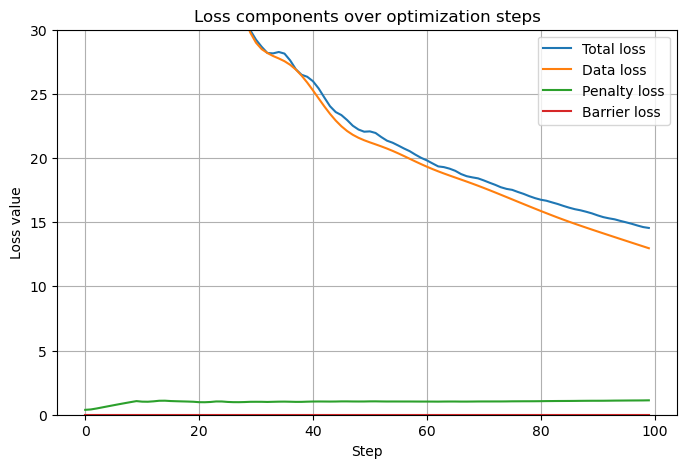

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(logs['total_loss'], label='Total loss')
plt.plot(logs['data_loss'], label='Data loss')
plt.plot(logs['penalty'], label='Penalty loss')
plt.plot(logs['barrier'], label='Barrier loss')
plt.xlabel('Step')
plt.ylabel('Loss value')
plt.legend()
plt.grid(True)
plt.title('Loss components over optimization steps')
plt.ylim(0,30)
plt.show()


### Plot posteriors

In [ ]:
full_calibrated_paramsets = pd.read_csv('calibrated_sets_unifRandom.csv')

In [19]:
n_inits = np.shape(x0)[0]
uset_tiled = np.tile(default_params[u_params].values[0], (n_inits,1))
opt_sets = np.concatenate([uset_tiled,x_opt],axis=1)
full_calibrated_paramsets = pd.DataFrame(opt_sets,columns=default_params.columns.values)


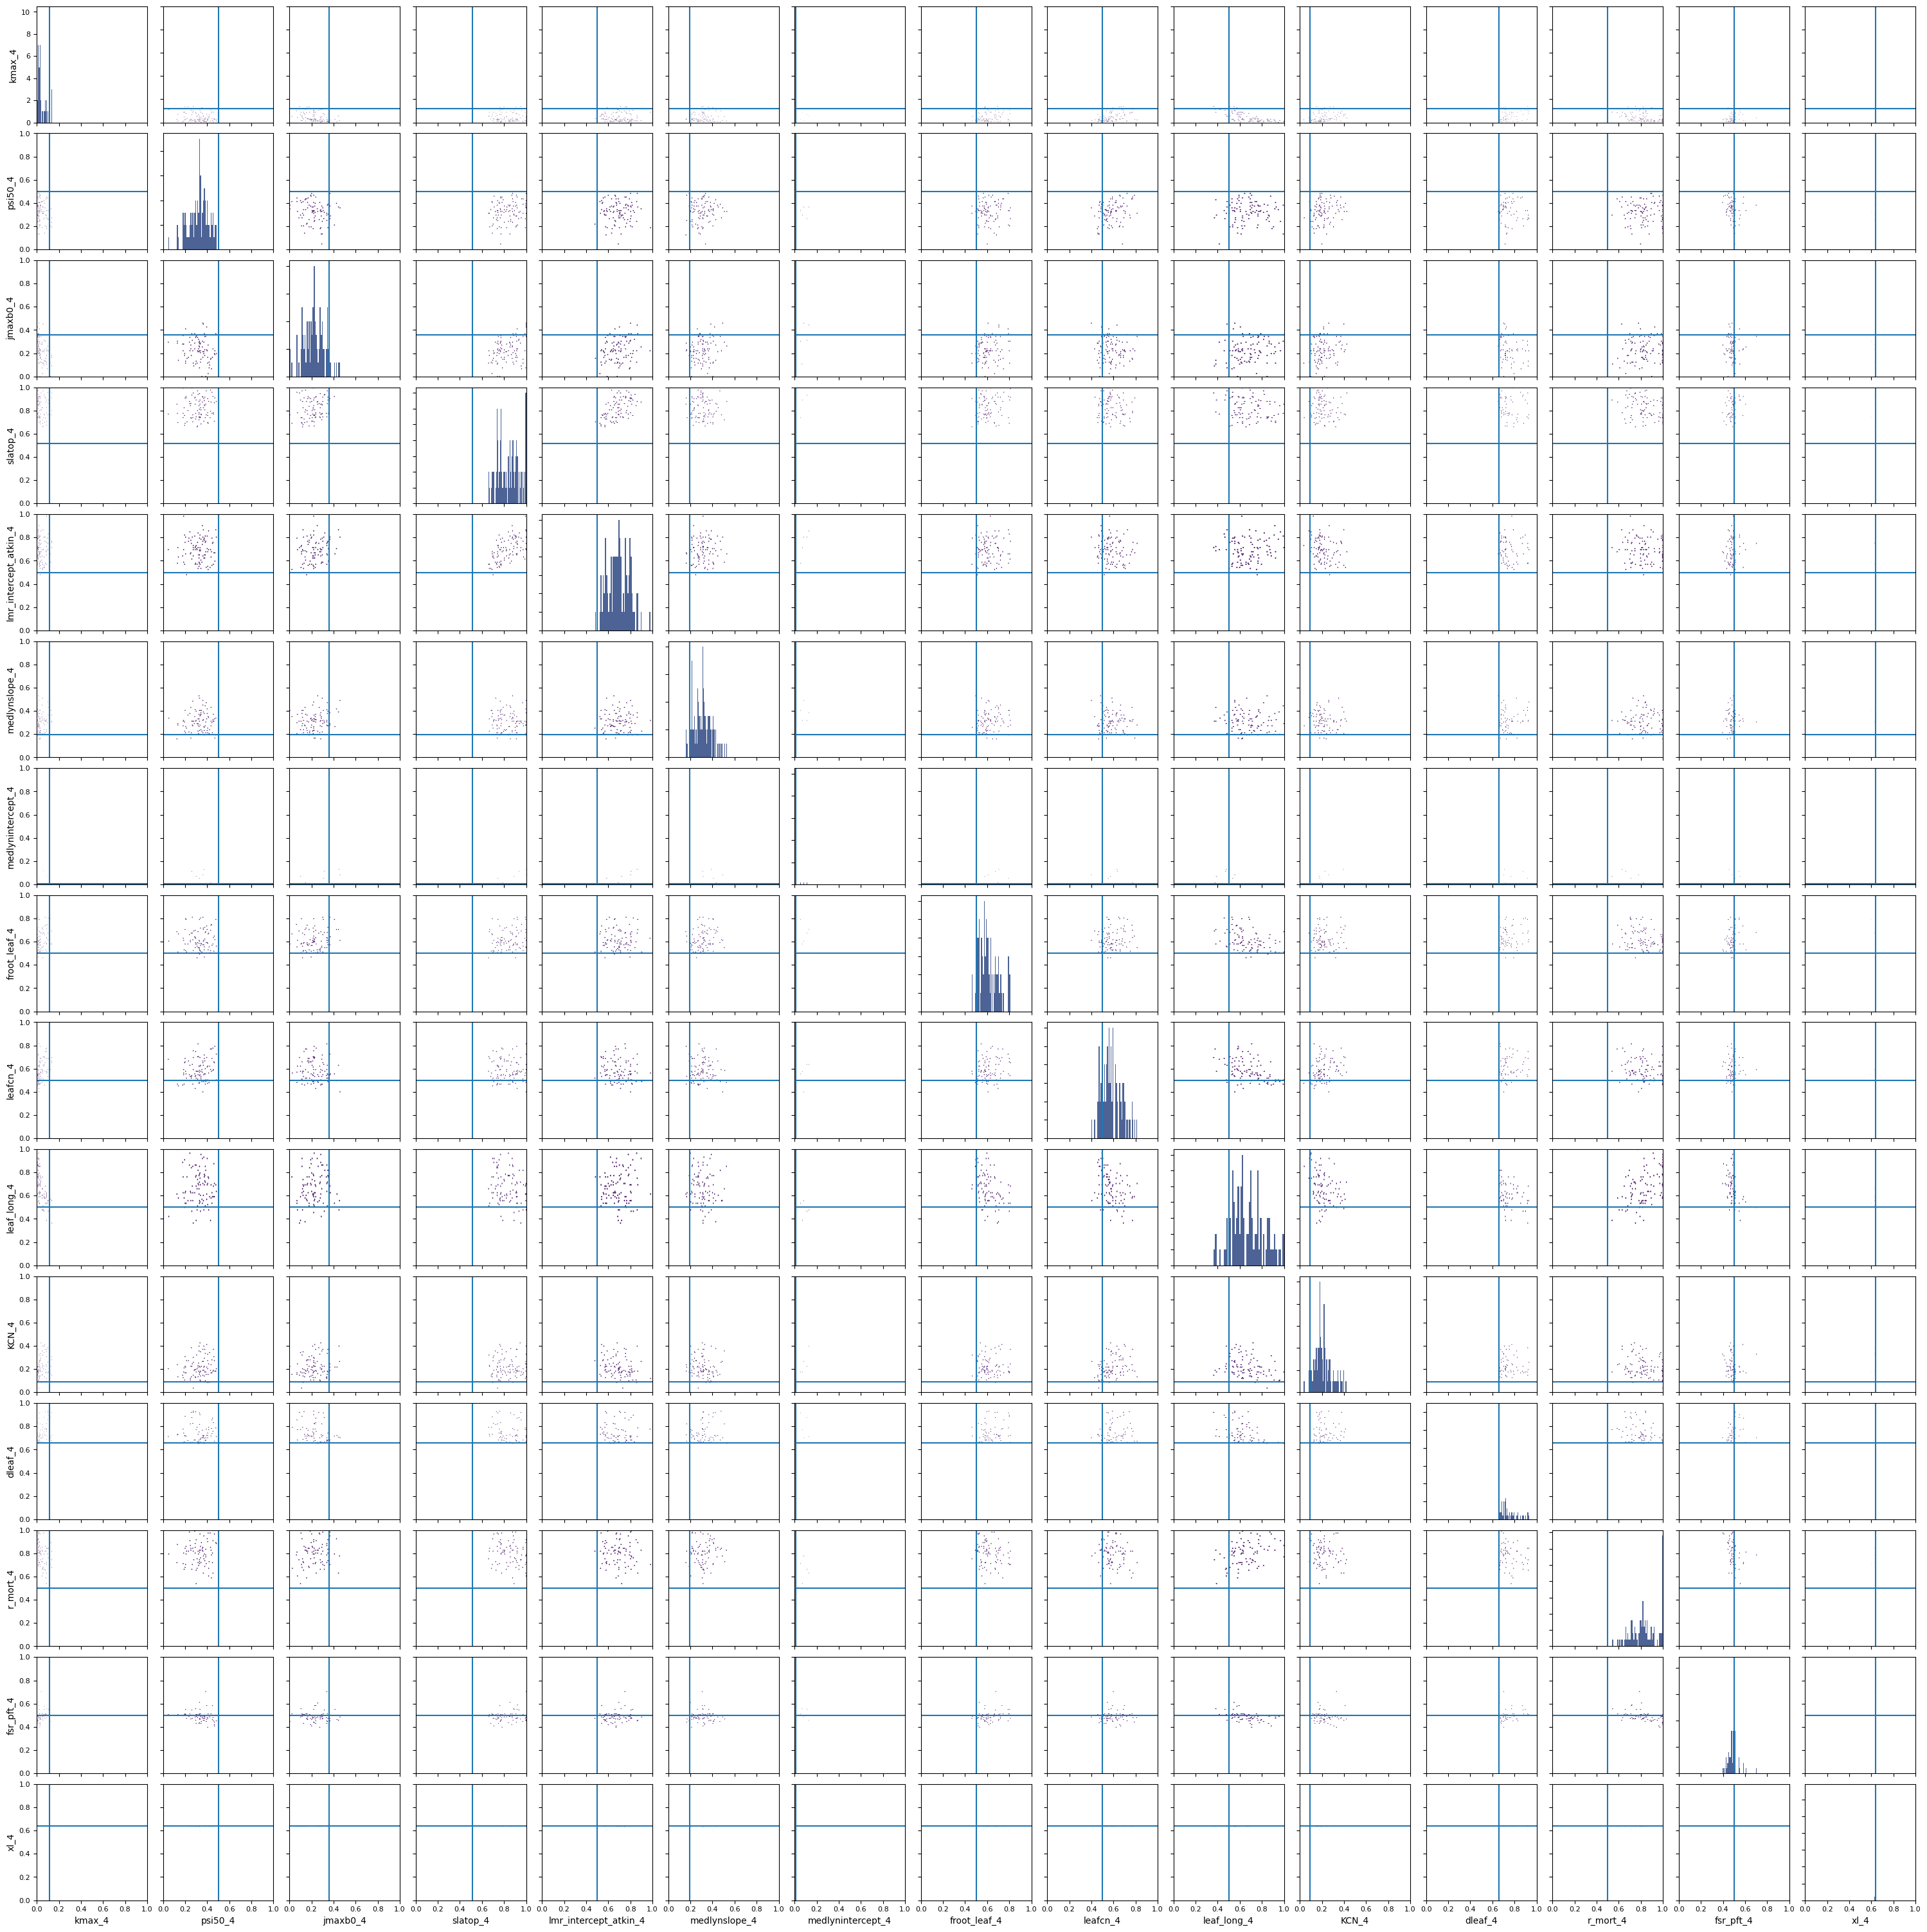

In [21]:
# Define LEAP colors
leap_colors = ['#B9D9EB', '#00796B', '#012169']

# Prepare data
pft = 4
pft_param_names = [f"{param}_{pft}" for param in pft_params]
data = full_calibrated_paramsets[pft_param_names]

n = len(pft_param_names)

# Set plot-wide styles
plt.rcParams.update({
    'font.size': 10,         # Font size
    'axes.labelsize': 12,    # Axis label size
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8,
    'axes.linewidth': 0.8,   # Thin frame lines
    'savefig.dpi': 300,
})

fig, axes = plt.subplots(n, n, figsize=(2*n, 2*n))  # Larger, scalable size

for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 1D histogram on the diagonal
            ax.hist(data[pft_param_names[i]], bins=50, color=leap_colors[2], alpha=0.7)
            ax.axvline(default_params[pft_param_names[i]].values)
            ax.set_xlim([0,1])
        else:
            # 2D hexbin on the off-diagonals
            hb = ax.hexbin(
                data[pft_param_names[j]],
                data[pft_param_names[i]],
                gridsize=50,
                #cmap='Blues',
                vmin=0,
                vmax=20,
                mincnt=1,           # Only show bins with data
                linewidths=0
            )
            # Fix hexbin color to LEAP navy color
            #hb.set_cmap('Blues')
            #hb.set_array(hb.get_array()*0+1)  # Uniform color intensity
            #hb.set_edgecolor('none')
            #hb.set_facecolor(leap_colors[2])  # Dark navy
            ax.axvline(default_params[pft_param_names[j]].values)
            ax.axhline(default_params[pft_param_names[i]].values)
            ax.set_ylim([0,1])
            ax.set_xlim([0,1])

        # Clean ticks
        if i < n-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(pft_param_names[j], fontsize=10)
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(pft_param_names[i], fontsize=10)

plt.tight_layout(pad=0.5)
#plt.savefig('./figs/hexbin_scattermatrix_pftparams_pft'+str(pft)+'.png', dpi = 300)

In [16]:
60/20

3.0

In [17]:
3/20

0.15